In [1]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
# -------------------------
# Config
# -------------------------
DATA_PATH = "ENSO_dataset_balanced.csv"
TARGET_COL = "NINO3.4"
FREQ = "ME"
CONTEXT_LENGTH = 12          # Panjang urutan input untuk Transformer
BATCH_SIZE = 32
NUM_EPOCHS = 150             # Ditingkatkan dari 50
LR = 5e-4                    # Disesuaikan (sedikit lebih rendah)

In [3]:
# Hyperparameter spesifik Transformer (ditingkatkan)
D_MODEL = 128                # Dimensi embedding dan model, ditingkatkan dari 64
NHEAD = 8                    # Jumlah attention heads (D_MODEL harus habis dibagi NHEAD)
NUM_ENCODER_LAYERS = 3       # Jumlah lapisan encoder Transformer, ditingkatkan dari 2
DIM_FEEDFORWARD = 256        # Dimensi lapisan feedforward di Transformer (2 * D_MODEL), ditingkatkan dari 128
DROPOUT = 0.1                # Tingkat dropout
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

In [4]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
# -------------------------
# Load & prepare series
# -------------------------
df = pd.read_csv(DATA_PATH)
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in CSV.")

df.index = pd.date_range(start="1950-01-01", periods=len(df), freq=FREQ)
df = df.sort_index()

series = df[TARGET_COL].astype(float).values.reshape(-1, 1)

scaler_y = StandardScaler()
series_scaled = scaler_y.fit_transform(series).flatten()

In [6]:
# -------------------------
# Create sequences (sliding window)
# -------------------------
def create_sequences(series_array, context_len):
    X, y = [], []
    for i in range(len(series_array) - context_len):
        X.append(series_array[i:i+context_len])
        y.append(series_array[i+context_len])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

X_all, y_all = create_sequences(series_scaled, CONTEXT_LENGTH)
n_windows = len(X_all)
print("Total windows:", n_windows)

Total windows: 1209


In [7]:
# -------------------------
# Train / Test split (time-wise)
# -------------------------
train_size = int(n_windows * 0.8)
X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_test = X_all[train_size:]
y_test = y_all[train_size:n_windows] # Koreksi: y_test harus dari bagian test_set

test_indices = np.arange(len(y_test))

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
# Penting: shuffle=False untuk time series
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
# -------------------------
# Transformer model
# -------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # pe shape: (max_len, d_model) -> unsqueeze for batch: (max_len, 1, d_model)
        # For batch_first=True in TransformerEncoder, we need (1, max_len, d_model)
        self.register_buffer('pe', pe.unsqueeze(0)) # Unsqueeze at dim 0 for batch_first compat

    def forward(self, x):
        # x shape: (batch_size, sequence_length, d_model)
        # pe shape: (1, max_len, d_model)
        # Slice pe to match sequence length of x
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [9]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        # Input layer untuk memproyeksikan data 1D ke d_model dimensi
        self.encoder_input_layer = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        # Transformer Encoder untuk menumpuk beberapa lapisan
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Output layer untuk memprediksi nilai tunggal
        self.decoder_output_layer = nn.Linear(d_model, 1)

    def forward(self, src):
        # src shape: (batch_size, sequence_length)
        # Tambahkan dimensi input_dim (1) karena TransformerLayer mengharapkan 3D input
        src = src.unsqueeze(-1) # (batch_size, sequence_length, input_dim)

        # Proyeksikan input ke dimensi d_model
        src = self.encoder_input_layer(src) # (batch_size, sequence_length, d_model)

        # Tambahkan positional encoding
        src = self.positional_encoding(src)

        # Lewatkan melalui Transformer Encoder
        output = self.transformer_encoder(src) # (batch_size, sequence_length, d_model)

        # Kita memprediksi nilai berikutnya berdasarkan seluruh sequence.
        # Umumnya mengambil output dari token terakhir dalam sequence untuk prediksi satu langkah.
        last_output_token = output[:, -1, :] # (batch_size, d_model)

        # Dekode ke prediksi akhir
        prediction = self.decoder_output_layer(last_output_token) # (batch_size, 1)

        return prediction.squeeze(-1) # (batch_size,)

In [10]:
# Instansiasi model Transformer
model = TimeSeriesTransformer(
    input_dim=1,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(DEVICE)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [12]:
# -------------------------
# Training loop
# -------------------------
best_val_loss = float("inf")
model_save_path = "best_transformer_nino34.pth"

# Tambahkan Learning Rate Scheduler (CosineAnnealingLR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [13]:
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Langkah scheduler di setiap akhir epoch
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            preds = model(xb)
            val_loss += criterion(preds, yb).item() * xb.size(0)
    val_loss /= len(test_loader.dataset)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}   Train MSE: {train_loss:.6f}   Val MSE: {val_loss:.6f}")

print("Training finished. Best val MSE:", best_val_loss)

Epoch 001   Train MSE: 0.375199   Val MSE: 0.167626
Epoch 005   Train MSE: 0.224138   Val MSE: 0.162785
Epoch 010   Train MSE: 0.180815   Val MSE: 0.166411
Epoch 015   Train MSE: 0.175258   Val MSE: 0.161543
Epoch 020   Train MSE: 0.177248   Val MSE: 0.172765
Epoch 025   Train MSE: 0.166562   Val MSE: 0.180433
Epoch 030   Train MSE: 0.166383   Val MSE: 0.160659
Epoch 035   Train MSE: 0.164945   Val MSE: 0.175649
Epoch 040   Train MSE: 0.163407   Val MSE: 0.204331
Epoch 045   Train MSE: 0.162459   Val MSE: 0.221590
Epoch 050   Train MSE: 0.155530   Val MSE: 0.181941
Epoch 055   Train MSE: 0.152214   Val MSE: 0.185720
Epoch 060   Train MSE: 0.147310   Val MSE: 0.198678
Epoch 065   Train MSE: 0.139152   Val MSE: 0.191228
Epoch 070   Train MSE: 0.138461   Val MSE: 0.199888
Epoch 075   Train MSE: 0.141760   Val MSE: 0.188326
Epoch 080   Train MSE: 0.138935   Val MSE: 0.216534
Epoch 085   Train MSE: 0.134228   Val MSE: 0.223136
Epoch 090   Train MSE: 0.134831   Val MSE: 0.236596
Epoch 095   

In [14]:

# load best model
model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()

TimeSeriesTransformer(
  (encoder_input_layer): Linear(in_features=1, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder_output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [15]:
# -------------------------
# Predict on test set
# -------------------------
preds_scaled = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(DEVICE)
        p = model(xb).cpu().numpy().reshape(-1)
        preds_scaled.append(p[0])
preds_scaled = np.array(preds_scaled, dtype=np.float32)

preds_unscaled = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [16]:
# -------------------------
# Metrics
# -------------------------
mae = mean_absolute_error(y_test_unscaled, preds_unscaled)
rmse = math.sqrt(mean_squared_error(y_test_unscaled, preds_unscaled))

range_y_test = np.max(y_test_unscaled) - np.min(y_test_unscaled)
nrmse = rmse / range_y_test if range_y_test != 0 else float('inf')

r2 = r2_score(y_test_unscaled, preds_unscaled)

mape = mean_absolute_percentage_error(y_test_unscaled, preds_unscaled)

In [17]:
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test NRMSE: {nrmse:.4f}")
print(f"Test R2 Score: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")

Test MAE: 0.2912
Test RMSE: 0.4267
Test NRMSE: 0.1299
Test R2 Score: 0.2494
Test MAPE: 0.2565


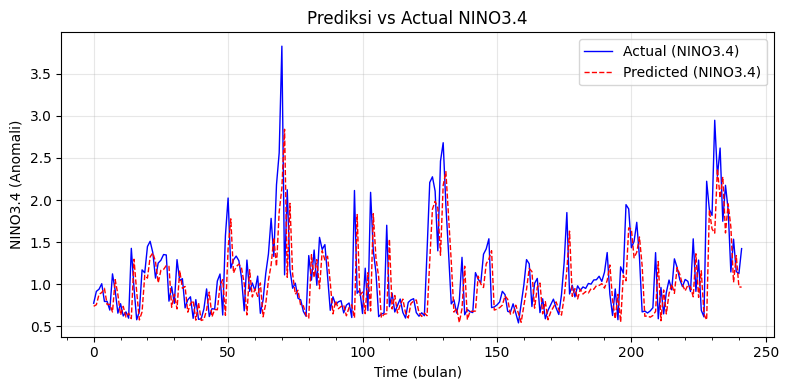

In [18]:
# -------------------------
# Plot Prediksi vs Aktual
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(test_indices, y_test_unscaled, label="Actual (NINO3.4)", color='blue', linestyle='-', linewidth=1, marker='')
plt.plot(test_indices, preds_unscaled, label="Predicted (NINO3.4)", color='red', linestyle='--', linewidth=1, marker='')

plt.xlabel("Time (bulan)")
plt.ylabel("NINO3.4 (Anomali)")
plt.title("Prediksi vs Actual NINO3.4")
plt.legend()
plt.grid(alpha=0.3)

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(50))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(10))

plt.tight_layout()
plt.show()

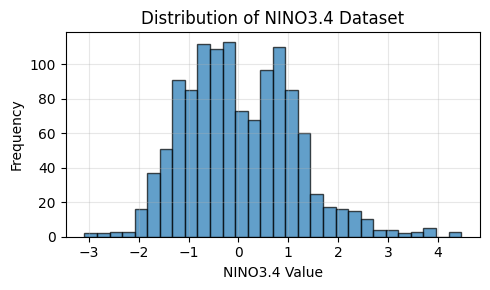

In [19]:
# -------------------------
# Plot Distribusi Dataset (NINO3.4)
# -------------------------
plt.figure(figsize=(5, 3))
plt.hist(series.flatten(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("NINO3.4 Value")
plt.ylabel("Frequency")
plt.title("Distribution of NINO3.4 Dataset")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
